# 1 Author

**Student Name**: Sneha Gadade 

**Student ID**:  220798659


# 2 Problem formulation

Using the MLEnd London Sounds dataset, build a machine learning pipeline that takes as an input an audio segment and predicts whether the audio segment has been recorded indoors or outdoors.

# 3 Machine Learning pipeline

Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. 

**Data preparation pipeline:**

We will define a class **PreprocAndFeatureExtraction** to extract features from all audio files. How these features are extracted is explained in **Transformation Stage**

**Feature selection:**

So from the extracted features, not all features are necessary to train the model. How these features are selected  is explained in **Feature Selection** section

**ML pipeline:**

ML pipeline is built after confirming following steps. 

At each step we will use cross validation using 7-Folds.

**Step 1:**
We will check training accuracy and validation accuracy for all folds using multiple models without hyperparameter tuning.

**Step 2:**
After step 1, we will perform hyperparameter tuning manually for all models to get best hyperparameter. The hyperparameters mentioned in **Hyperparameter Tuning(Manual)** Section are already tuned.

**Step 3:**
Based on training accuracy and validation accuracy in step 2, we will select top 3 best performing models and **combine the predictions** using **VotingClassifier** from scikit-learn.

**Prediction Pipeline:**

In the **Predicting on new audio samples** section, we will define **PredictSurrounding** class. **predictOnAudio** method in this class takes audio sample path as **input** and predicts wether the audio is recorded in **Indoor** surrounding or **Outdoor** surrounding

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

Extraction of features is a very important part in analyzing and finding relations between different things. The data provided of audio cannot be understood by the models directly to convert them into an understandable format feature extraction is used.

We are goining to extract following features from the audio.

4 features from (Power, Pitch Mean, Pitch Standard deviation, Voiced Frequency), 49 features from Amplitude features through histogram, 1 feature from Zero crossing rate ratio, 5 features from Spectral centroid (mean,standard deviation, quintile(0.25, 0.50, 0.75)), 5 features from Spectral rolloff and 20 features from MFCC.
Total number of features to be extracted are 84.



**Power, Pitch Mean, Pitch Standard deviation, Voiced Frequency**
Audio files are complex data types. Specifically they are discrete signals or time series, consisting of values on a 1D temporal grid. These values are known as samples themselves. The sampling frequency is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.


In [1]:

from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import sklearn
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.simplefilter("ignore")

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Describing all the feature extraction process and the reason for that feature extraction on one sample audio.

In [2]:
sample_audio, fs = librosa.load('/content/drive/MyDrive/Data/MLEndLS/raw_audio/0001.wav', sr=44100 )

**Amplitude Features extracted using Histogram.**

Firstly, we will rescale the amplitude between 0-100. Then writing the function extract_sample_amplitude_features to extract the features from passed audio and get an array of features. the bins are defined as (0,100,2)
Showing how it works by taking one sample audio and extracting the features and plotting the histogram where it takes rescaled amplitude on x axis and density of all the amplitude present in that bin on y-axis.


In [3]:
def rescale_sample_amplitude(x):
    # rescale amplitude in 0-100
    return np.around((x - x.min())/(x.max()-x.min())*100)

def extract_sample_amplitude_features(x):
    # extracting features from rescaled amplitude values of a histogram with fixed bins. 
    bins = list(range(0,100,2))
    amplitude_features, _ = np.histogram(rescale_sample_amplitude(x), bins = bins, density = True)
    return amplitude_features

In [4]:
hist_features = extract_sample_amplitude_features(sample_audio)

Sample audio is passed through funnction extract_sample_amplitude_features and we get an array of amplitude features. 



In [5]:
hist_features

array([7.09360724e-06, 3.54680362e-06, 1.18226787e-06, 5.91133937e-06,
       1.18226787e-05, 1.89162860e-05, 1.30049466e-05, 2.95566968e-05,
       6.02956615e-05, 1.26502662e-04, 1.25320395e-04, 2.13990485e-04,
       3.28670469e-04, 5.04828382e-04, 6.98720313e-04, 1.18581468e-03,
       1.72138202e-03, 2.48749161e-03, 4.12493261e-03, 6.07331007e-03,
       8.79607298e-03, 1.25876060e-02, 1.70518495e-02, 2.33758004e-02,
       2.93261546e-02, 3.55318787e-02, 4.11559269e-02, 4.46672625e-02,
       4.64524870e-02, 4.48493318e-02, 4.16548440e-02, 3.46877394e-02,
       2.83791580e-02, 2.24264393e-02, 1.71464310e-02, 1.21442556e-02,
       8.04060381e-03, 5.33321038e-03, 3.31980819e-03, 1.99803271e-03,
       1.27921384e-03, 8.15764833e-04, 4.90641168e-04, 3.12118719e-04,
       2.13990485e-04, 1.12315448e-04, 6.97538045e-05, 2.24630896e-05,
       1.65517502e-05])

From histogram we are able to observe that near bin 58-60 and 60-62 the dinsity is high. Hence for all the audios this value differs and we get an important feature to distinguish which audio is indoors and outdoors.

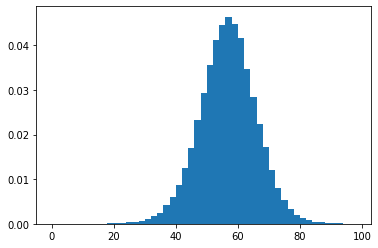

In [6]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(rescale_sample_amplitude(sample_audio), bins= list(range(0,100,2)), density=True)

**Zero crossing rate ratio**

The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds. We have to normalize the value, as the length of the  audio differes from the each other. As we have to compair these values they must be in same range. hence taking the ratio of the zero crossing rate with the length of the sample.




In [7]:
def extract_zero_crossings_sample_ratio_features(x):
        
        zero_crossings = librosa.zero_crossings(x, pad=False)
        ratio = sum(zero_crossings)/float(x.shape[0])
        return np.array([ratio])

In [8]:
zero_Crossing= extract_zero_crossings_sample_ratio_features(sample_audio)
zero_Crossing

array([0.04526872])

**Spectral centroid**

It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in audio are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.

In [9]:
def sample_normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def features_from_sample_spectral_centroids(x, sr):
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=44100)[0]
    #before calculating the mean std and quantile we have to normalize the spectral centroid. 
    spectral_centroids = sample_normalize(spectral_centroids)
    spectral_centroids_mean = np.mean(spectral_centroids)
    spectral_centroids_std = np.std(spectral_centroids)
    spectral_centroids_quantiles = np.quantile(spectral_centroids, [0.25, 0.5, 0.75])
    # using .concatenate to make an one array 
    return np.concatenate((np.array([spectral_centroids_mean, spectral_centroids_std]), spectral_centroids_quantiles))

When audio is passed through the function features_from_sample_spectral_centroids we will get an array of 5 values first is the mean followed by standard deviation then the quantile of 0.25, 0.50, 0.75. Calculating the quantile so that we get features from 25 to 75 quantile only, so that no outliers are considered while extracting the features.
    

In [10]:
features_from_sample_spectral_centroids(sample_audio, sr=44100)

array([0.49479663, 0.18647137, 0.36965395, 0.5131242 , 0.61321153])

**Spectral rolloff**

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 75%, lies. It also gives results for each frame.

In [11]:
def features_from_spectral_rolloff(x, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
    spectral_rolloff = normalize(spectral_rolloff)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    spectral_rolloff_std = np.std(spectral_rolloff)
    spectral_rolloff_quantiles = np.quantile(spectral_rolloff, [0.25, 0.5, 0.75])
    return np.concatenate((np.array([spectral_rolloff_mean, spectral_rolloff_std]), spectral_rolloff_quantiles))

**MFCC — Mel-Frequency Cepstral Coefficients**

This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

.mfcc is used to calculate mfccs of a signal.


In [12]:
def features_from_sample_mfcc(x):
        mfccs = librosa.feature.mfcc(x, sr=44100)
        mfcc_sample_features = np.mean(mfccs, axis=1)
        return mfcc_sample_features

In [13]:
mfcc_sample = features_from_sample_mfcc(sample_audio) 
mfcc_sample

array([-2.4140570e+02,  1.5507394e+02, -3.4950432e+01,  4.7682121e+01,
       -3.8543890e+00,  2.7368311e+01, -2.0701797e+00,  2.2997143e+01,
       -9.3506088e+00,  1.5785603e+01,  1.6699475e+00,  3.7509654e+00,
        8.1164949e-03,  7.9330955e+00, -3.2082958e+00, -1.7620677e-01,
        7.7564955e+00, -8.2732630e+00,  1.6583691e+01, -8.9274712e+00],
      dtype=float32)

# 5 Modelling



Using following models:
Logistic Regression, Linear SVC, SVC, K-Neighbors Classifier,
Random Forest Classifier, Gradient Boosing Classifier, Gaussian Naive Baye.

The maximum accuracy is coming from SVC classifier, but to increase accuracy we are combining the top 3 prediction in **ensemble** This combines top 3 model's predictions hence increases the overall accuracy.

# 6 Methodology


When we are training our models we are using 7 fold cross validation.
During each fold we are calculating tarining and validation accuracy. We take mean of these taraining and validation accuracies to get final training and validation accuracy. Finally, each model is tuned(Hyperparameter Tuning) and cross validated using this method.

After observing the performance of tunned models, we select 3 best performing models to combine the predictions. For this combine of predictions we use same cross validation strategy to obtain final training and valudation accuracy.




# 7 Dataset


We will ectract all the audio samples from provided zip files to raw_audio folder. **save_training_data** method in **PreprocAndFeatureExtraction** class extracts features and saves **data.csv** file in data folder on google drive. We can use this file in basic as well as advanced section.
We will use all audio files to extract features where it is possible. For some files, we get an error while extracting features. These corrupted files are automatically handled using exception handling in Python.  

Loading a few useful Python libraries and mounting our personal Google Drive storage system 

Defining base path 

In [14]:
BASE_PATH = '/content/drive/MyDrive/Data/MLEndLS/'

In [15]:
#listing the MLEndLS zip files 
ZIP_FILES = ["MLEndLS_1.zip", "MLEndLS_2.zip", "MLEndLS_3.zip", "MLEndLS_4.zip", "MLEndLS_5.zip" ]

In [16]:
#to get consistent features defining the sampling rate.Default sr is 22kHz. We can override the sr by
SAMPLING_RATE = 44100

In [17]:
#listing the column names 
LABEL_COLUMN_NAMES = ["area", "spot", "in_out"]

Data preparation and feature extraction


creating a class which consist of functions which are required for preprocessing, feature extraction and to save the extracted features in a .csv file.

In [18]:
class PreprocAndFeatureExtraction:
    def __init__(self, base_path, zip_files, sampling_rate, label_column_names= None, unzip_data=False): #Unzip=True unzips all files to raw_audio folder in google drive
        self.basePath = base_path
        self.zipFiles = zip_files
        self.labelsDF = pd.read_csv(self.basePath + 'MLEndLS.csv')
        self.labelsDFColumns = list(self.labelsDF.columns)
        self.fileIDs = self.labelsDF["file_id"].to_numpy().tolist()
        
        self.samplingRate = sampling_rate
        self.winLen = 0.02
        self.bins = list(range(0,100,2))
        self.unzipData = unzip_data
        self.featureColumnNames = ["feature_power","feature_pitch_mean","feature_pitch_std","feature_voiced_fr"] + [f"feature_hist_{x}" for x in range(len(self.bins)-1)] + ["feature_zero_crossings_ratio"] + [f"feature_spectral_centroid_{x}" for x in range(0,5,1)] + [f"feature_spectral_rolloff_{x}" for x in range(0,5,1)] + [f"feature_MFCC_{x}" for x in range(0,20,1)]
        if label_column_names:
            self.labelColumnNames = label_column_names
            self.labelColumnsIndexes = [self.labelsDFColumns.index(x) for x in self.labelColumnNames]
        
        else:
            self.labelColumnNames = None
        if self.unzipData:
            for zip_filepath in tqdm(self.zipFiles):
                with zipfile.ZipFile(self.basePath + zip_filepath, 'r') as zip_ref:
                    zip_ref.extractall(self.basePath + 'raw_audio/')
    
    def getPitch(self, x):
        #winLen = 0.02
        p = self.winLen*self.samplingRate
        frame_length = int(2**int(p-1).bit_length())
        hop_length = frame_length//2
        f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=self.samplingRate,
                                                 frame_length=frame_length,hop_length=hop_length)
        return f0,voiced_flag

    def rescale_amplitude(self, x):
        # rescale amplitude in 0-100
        return np.around((x - x.min())/(x.max()-x.min())*100)

    def normalize(self, x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)    

    def features_power_pitch_voicedFr(self, x):
        x = x/np.max(np.abs(x))
        f0, voiced_flag = self.getPitch(x)
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        return np.array([power,pitch_mean,pitch_std,voiced_fr])     

    def extract_amplitude_features(self, x):
        #extracting features from rescaled amplitude values of a histogram with fixed bins.
        amplitude_features, _ = np.histogram( self.rescale_amplitude(x), bins = self.bins, density = True)
        return amplitude_features       
    
    def extract_zero_crossings_ratio_features(self, x):
        zero_crossings = librosa.zero_crossings(x, pad=False)
        ratio = sum(zero_crossings)/float(x.shape[0])
        return np.array([ratio])

    def features_from_spectral_centroids(self, x):
        spectral_centroids = librosa.feature.spectral_centroid(x, sr= self.samplingRate)[0]
        spectral_centroids = self.normalize(spectral_centroids)
        spectral_centroids_mean = np.mean(spectral_centroids)
        spectral_centroids_std = np.std(spectral_centroids)
        spectral_centroids_quantiles = np.quantile(spectral_centroids, [0.25, 0.5, 0.75])
        return np.concatenate((np.array([spectral_centroids_mean, spectral_centroids_std]), spectral_centroids_quantiles))    

    def features_from_spectral_rolloff(self, x):
        spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=self.samplingRate)[0]
        spectral_rolloff = self.normalize(spectral_rolloff)
        spectral_rolloff_mean = np.mean(spectral_rolloff)
        spectral_rolloff_std = np.std(spectral_rolloff)
        spectral_rolloff_quantiles = np.quantile(spectral_rolloff, [0.25, 0.5, 0.75])
        return np.concatenate((np.array([spectral_rolloff_mean, spectral_rolloff_std]), spectral_rolloff_quantiles))    
    

    def features_from_mfcc(self, x):
        mfccs = librosa.feature.mfcc(x, sr=self.samplingRate)
        mfcc_features = np.mean(mfccs, axis=1)
        return mfcc_features

    def save_training_data(self):
        file_ids = []
        participant_ids = []
        corrupt_files = []
        features = []
        labels = []
        for index in tqdm(range(self.labelsDF.shape[0])):
            filename = self.labelsDF.iloc[index,self.labelsDFColumns.index("file_id")]
            participant_ID = self.labelsDF.iloc[index,self.labelsDFColumns.index("Participant")]
            try:
                audio, _ = librosa.load(self.basePath + 'raw_audio/' + filename, sr= self.samplingRate)
                
                if self.labelColumnNames:
                    label = self.labelsDF.iloc[index, self.labelColumnsIndexes]
                power_pitch_voice_features = self.features_power_pitch_voicedFr(audio)
                hist_features = self.extract_amplitude_features(audio)
                zero_crossing_features = self.extract_zero_crossings_ratio_features(audio)
                spectral_centroid_features = self.features_from_spectral_centroids(audio)
                spectral_rolloff_features = self.features_from_spectral_rolloff(audio)
                mfcc_features = self.features_from_mfcc(audio)
                file_ids.append(filename)
                participant_ids.append(participant_ID)
                features.append(np.concatenate((power_pitch_voice_features, hist_features, zero_crossing_features, spectral_centroid_features, spectral_rolloff_features, mfcc_features)))
                if self.labelColumnNames:
                    labels.append(label)
            except Exception:
                corrupt_files.append(filename)
                pass
        
        if labels:
            data_df = pd.DataFrame(np.concatenate((np.array(features), np.array(labels)), axis=1))
            data_df.columns =  self.featureColumnNames + self.labelColumnNames
        else:
            data_df = pd.DataFrame(np.array(features))
            data_df.columns =  self.featureColumnNames
        print(f"\nFollowing are the corrupted files : {corrupt_files}")
        
        data_df["file_id"] = file_ids
        data_df["Participant"] = participant_ids
        data_df.set_index("file_id", inplace=True)
        print(f"Saving data.csv at location: {self.basePath+ 'data/data.csv'}")
        data_df.to_csv(self.basePath+"data/data.csv")
        print("data.csv file saved successfully!")
        

In [19]:
feature_extractor = PreprocAndFeatureExtraction(base_path = BASE_PATH, zip_files= ZIP_FILES, sampling_rate= SAMPLING_RATE, label_column_names=LABEL_COLUMN_NAMES, unzip_data=False)

In [20]:
#uncomment when required   
#feature_extractor.save_training_data()

# FEATURE EXPLORATION

After feature extraction, we create a dataframe with NxM size, where, N = 
Number of samples(corrupted excluded) and M= number of features. Finally, save this dataframe in csv files


In [21]:
data_df = pd.read_csv('/content/drive/MyDrive/Data/MLEndLS/data/data.csv')

In [22]:
data_df.shape

(2498, 89)

In [23]:
data_df.head()

,file_id,feature_power,feature_pitch_mean,feature_pitch_std,feature_voiced_fr,feature_hist_0,feature_hist_1,feature_hist_2,feature_hist_3,feature_hist_4,...,feature_MFCC_14,feature_MFCC_15,feature_MFCC_16,feature_MFCC_17,feature_MFCC_18,feature_MFCC_19,area,spot,in_out,Participant
0,0001.wav,0.026341,86.945514,2.278420,0.016929,0.000007,0.000004,0.000001,0.000006,0.000012,...,-3.208296,-0.176207,7.756495,-8.273263,16.583691,-8.927471,british,street,outdoor,S151
1,0002.wav,0.010308,193.033652,34.995743,0.131796,0.000006,0.000010,0.000011,0.000016,0.000013,...,-2.241410,-6.907155,7.761998,-5.321468,-0.472251,3.177591,kensington,dinosaur,indoor,S127
2,0003.wav,0.005994,118.204789,13.032931,0.053735,0.000012,0.000024,0.000019,0.000009,0.000010,...,1.312150,16.873102,-15.021708,3.989271,0.975474,-7.571914,campus,square,outdoor,S18
3,0004.wav,0.016374,127.450592,18.197021,0.105263,0.000004,0.000001,0.000006,0.000013,0.000037,...,-3.125193,-3.332724,-7.483416,-2.683595,-6.539318,1.335392,kensington,hintze,indoor,S179
4,0005.wav,0.002628,160.158646,25.790774,0.067073,0.000006,0.000020,0.000044,0.000054,0.000059,...,-3.904656,-4.678980,0.059519,-1.126336,-2.390231,-3.384028,campus,square,outdoor,S176


In [24]:
data_df.describe()

,feature_power,feature_pitch_mean,feature_pitch_std,feature_voiced_fr,feature_hist_0,feature_hist_1,feature_hist_2,feature_hist_3,feature_hist_4,feature_hist_5,...,feature_MFCC_10,feature_MFCC_11,feature_MFCC_12,feature_MFCC_13,feature_MFCC_14,feature_MFCC_15,feature_MFCC_16,feature_MFCC_17,feature_MFCC_18,feature_MFCC_19
count,2498.000000,2498.000000,2498.000000,2498.000000,2.498000e+03,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,...,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,0.013476,152.615031,21.440425,0.085005,8.935341e-06,0.000013,0.000021,0.000033,0.000048,0.000069,...,-1.277239,0.963125,-0.503860,-1.144321,-0.611351,-1.001364,-2.615357,0.931158,-1.921729,-1.721573
std,0.010126,77.823798,21.753945,0.079401,8.459688e-06,0.000018,0.000029,0.000051,0.000061,0.000086,...,8.041163,7.978711,7.374211,6.683425,5.765171,6.000075,6.643227,5.859623,4.963915,4.359640
min,0.000433,0.000000,0.000000,0.000000,5.445704e-07,0.000000,0.000000,0.000000,0.000000,0.000000,...,-35.309093,-42.657978,-36.074566,-44.252239,-24.341990,-23.571871,-35.412495,-22.209190,-21.718390,-17.695683
25%,0.006571,114.553856,7.919292,0.044672,4.250731e-06,0.000004,0.000006,0.000010,0.000015,0.000022,...,-6.119608,-3.382371,-5.039912,-4.236716,-4.076854,-4.751872,-5.997054,-2.412093,-4.813450,-4.146958
50%,0.010588,141.344408,15.342969,0.075938,6.458580e-06,0.000009,0.000013,0.000021,0.000032,0.000045,...,-0.654440,1.176238,-1.102207,-0.627895,-0.827250,-1.276090,-2.146031,1.020563,-1.762822,-1.800952
75%,0.017707,199.383685,26.469406,0.102339,1.077744e-05,0.000017,0.000026,0.000041,0.000061,0.000086,...,3.896582,5.642217,3.371547,2.817399,2.437554,2.159396,1.151718,3.881802,1.252018,0.793644
max,0.081043,449.941853,142.306083,0.973684,1.459321e-04,0.000531,0.000743,0.001366,0.000992,0.001284,...,24.678970,30.721502,35.883850,22.976562,36.488571,37.250141,24.084768,31.662004,18.282879,20.127953


In [25]:
#defining all the coloumns which start with feature_ to ''features'.
features = [x for x in list(data_df.columns) if x.startswith('feature_')]

In [26]:

target = "in_out"
label= "label"

calculating the correlation matrix of all features and plotting it to ease the process of feature selection.

In [27]:
#correlation matrix of all features 
corr_mat = data_df[features].corr()

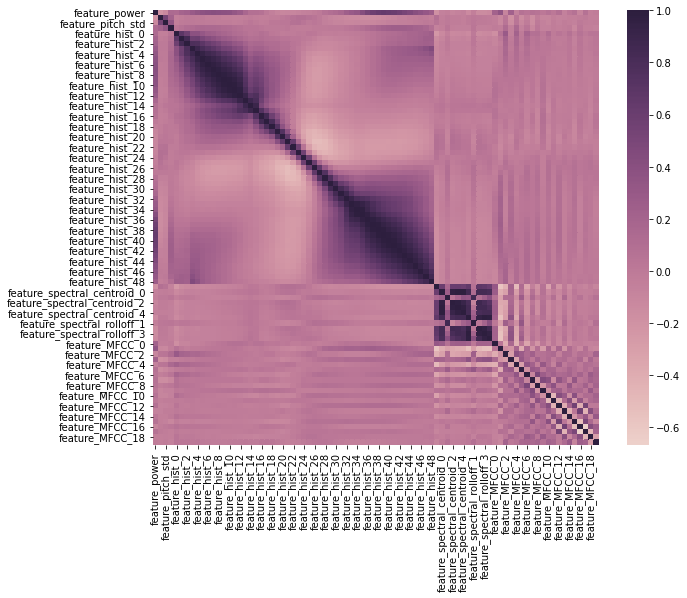

In [28]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap=sns.cubehelix_palette(as_cmap=True))

In [29]:
def label_function(val):
    return f'{val / 100 * len(data_df):.0f}\n{val:.0f}%'

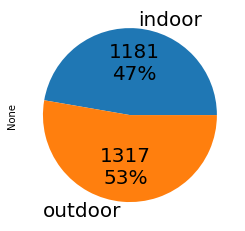

In [30]:
data_df.groupby(target).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20})

From this pie chart we can observer that the label column is almost balanced.

In [31]:
le = preprocessing.LabelEncoder()
le.fit(data_df[target])

LabelEncoder()

In [32]:
le.classes_

array(['indoor', 'outdoor'], dtype=object)

In [33]:
#changing labels from indoor outdoor to 0 and 1 
data_df[label] = le.transform(data_df[target])

In [34]:
data_df.head()

,file_id,feature_power,feature_pitch_mean,feature_pitch_std,feature_voiced_fr,feature_hist_0,feature_hist_1,feature_hist_2,feature_hist_3,feature_hist_4,...,feature_MFCC_15,feature_MFCC_16,feature_MFCC_17,feature_MFCC_18,feature_MFCC_19,area,spot,in_out,Participant,label
0,0001.wav,0.026341,86.945514,2.278420,0.016929,0.000007,0.000004,0.000001,0.000006,0.000012,...,-0.176207,7.756495,-8.273263,16.583691,-8.927471,british,street,outdoor,S151,1
1,0002.wav,0.010308,193.033652,34.995743,0.131796,0.000006,0.000010,0.000011,0.000016,0.000013,...,-6.907155,7.761998,-5.321468,-0.472251,3.177591,kensington,dinosaur,indoor,S127,0
2,0003.wav,0.005994,118.204789,13.032931,0.053735,0.000012,0.000024,0.000019,0.000009,0.000010,...,16.873102,-15.021708,3.989271,0.975474,-7.571914,campus,square,outdoor,S18,1
3,0004.wav,0.016374,127.450592,18.197021,0.105263,0.000004,0.000001,0.000006,0.000013,0.000037,...,-3.332724,-7.483416,-2.683595,-6.539318,1.335392,kensington,hintze,indoor,S179,0
4,0005.wav,0.002628,160.158646,25.790774,0.067073,0.000006,0.000020,0.000044,0.000054,0.000059,...,-4.678980,0.059519,-1.126336,-2.390231,-3.384028,campus,square,outdoor,S176,1


# Feature selection

If we consider a smaller number of features the less will be accuracy. The more features given to training the model the more will be the precision.

In [35]:
#selecting the features as 80.
num_features = 80

In [36]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=num_features)
# apply feature selection
X_selected = fs.fit_transform(data_df[features], data_df[label])
print(X_selected.shape)

(2498, 80)


In [37]:
scores = -np.log10(fs.pvalues_)
scores /= scores.max()

In [38]:
features_scores_df = pd.DataFrame()

In [39]:
features_scores_df["feature_name"] = features
features_scores_df["univariate_score"] = scores


# plotting univariate scores for features

Plotting univariate score to findout which feature is more useful.

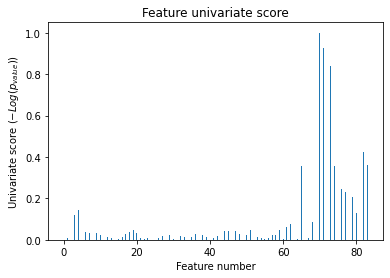

In [40]:
import matplotlib.pyplot as plt

X_indices = np.arange(len(features))
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

### Selecting best features

In [41]:
features_scores_df = features_scores_df.sort_values(by="univariate_score", ascending=False)
features_scores_df

,feature_name,univariate_score
70,feature_MFCC_6,1.000000
71,feature_MFCC_7,0.925022
73,feature_MFCC_9,0.839356
72,feature_MFCC_8,0.677310
69,feature_MFCC_5,0.477047
...,...,...
15,feature_hist_11,0.003415
14,feature_hist_10,0.002258
40,feature_hist_36,0.001296
24,feature_hist_20,0.000456


# 8 Results

Carry out your experiments here, explain your results.

In [42]:
selected_features = features_scores_df["feature_name"].values.tolist()[:num_features]

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [44]:
folds = 7
models = [LogisticRegression(), LinearSVC(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), GaussianNB()]
model_names = ["Logistic Regression", "Linear SVC", "SVC","K-Neighbors Classifier", "Decision Tree Classifier", "RandomForest Classifier", "Gradient Boosting Classifier","Gaussian Naive Bayes"]
model_scores_df = pd.DataFrame()
model_scores_df["model_name"] = model_names

In [45]:
kf = KFold(n_splits=folds)

accuracy_train = []
accuracy_validation = []

for model, model_name in zip(models,model_names):
    print(f"Training {model_name} using {folds}-fold cross validation")
    #classifier = make_pipeline(model)
    classifier = make_pipeline(StandardScaler(), model)
    accuracy_train_CV = []
    accuracy_validation_CV = []
    for train_index, val_index in kf.split(data_df[selected_features]):
        # print(f"TRAIN INDEX: START - {train_index[0]}, STOP - {train_index[-1]} VALIDATION_INDEX: START - {val_index[0]}, STOP - {val_index[-1]}")
        X_train, X_val = data_df[selected_features].iloc[train_index,:] , data_df[selected_features].iloc[val_index,:]
        y_train, y_val = data_df[label].iloc[train_index] , data_df[label].iloc[val_index]
        classifier.fit(X_train, y_train)
        accuracy_tr = classifier.score(X_train, y_train)
        accuracy_val = classifier.score(X_val, y_val)
        accuracy_train_CV.append(accuracy_tr)
        accuracy_validation_CV.append(accuracy_val)
    accuracy_train.append(np.mean(accuracy_train_CV))
    accuracy_validation.append(np.mean(accuracy_validation_CV))

model_scores_df["Train Accuracy"] = accuracy_train
model_scores_df["Validation Accuracy"] = accuracy_validation
        

Training Logistic Regression using 7-fold cross validation
Training Linear SVC using 7-fold cross validation
Training SVC using 7-fold cross validation
Training K-Neighbors Classifier using 7-fold cross validation
Training Decision Tree Classifier using 7-fold cross validation
Training RandomForest Classifier using 7-fold cross validation
Training Gradient Boosting Classifier using 7-fold cross validation
Training Gaussian Naive Bayes using 7-fold cross validation


In [46]:
model_scores_df

,model_name,Train Accuracy,Validation Accuracy
0,Logistic Regression,0.796370,0.776630
1,Linear SVC,0.797171,0.772621
2,SVC,0.863024,0.789444
3,K-Neighbors Classifier,0.794836,0.672542
4,Decision Tree Classifier,1.000000,0.666143
5,RandomForest Classifier,1.000000,0.748608
6,Gradient Boosting Classifier,0.908127,0.786236
7,Gaussian Naive Bayes,0.654258,0.644118


# Hyperparameter Tuning (Manual)

In [47]:
models = [LogisticRegression(max_iter=10000, penalty="elasticnet", C= 1.0, solver='saga', l1_ratio=1), LinearSVC(max_iter=10000, C=1e-1), SVC(max_iter=10000, gamma='auto', probability=True), KNeighborsClassifier(n_neighbors=450), DecisionTreeClassifier(max_depth=10, max_features=int(np.around(np.sqrt(num_features))), min_samples_split=10), RandomForestClassifier(n_estimators=250 ,max_depth=8, max_features=int(np.around(np.sqrt(num_features))), min_samples_split=25), GradientBoostingClassifier(n_estimators=200, max_features=60, min_samples_leaf=8), GaussianNB()]

#n_estimators=120, max_depth=6, max_features= int(np.around(np.sqrt(num_features))), min_samples_split=200

model_names = ["Logistic Regression", "Linear SVC", "SVC","K-Neighbors Classifier", "Decision Tree Classifier", "RandomForest Classifier", "Gradient Boosting Classifier","Gaussian Naive Bayes"]
model_scores_df = pd.DataFrame()
model_scores_df["model_name"] = model_names

In [48]:
kf = KFold(n_splits=folds)

accuracy_train = []
accuracy_validation = []

for model, model_name in zip(models,model_names):
    print(f"Training {model_name} using {folds}-fold cross validation")
    #classifier = make_pipeline(model)
    classifier = make_pipeline(StandardScaler(), model)
    accuracy_train_CV = []
    accuracy_validation_CV = []
    for train_index, val_index in kf.split(data_df[selected_features]):
        # print(f"TRAIN INDEX: START - {train_index[0]}, STOP - {train_index[-1]} VALIDATION_INDEX: START - {val_index[0]}, STOP - {val_index[-1]}")
        X_train, X_val = data_df[selected_features].iloc[train_index,:] , data_df[selected_features].iloc[val_index,:]
        y_train, y_val = data_df[label].iloc[train_index] , data_df[label].iloc[val_index]
        classifier.fit(X_train, y_train)
        accuracy_tr = classifier.score(X_train, y_train)
        accuracy_val = classifier.score(X_val, y_val)
        accuracy_train_CV.append(accuracy_tr)
        accuracy_validation_CV.append(accuracy_val)
    accuracy_train.append(np.mean(accuracy_train_CV))
    accuracy_validation.append(np.mean(accuracy_validation_CV))

model_scores_df["Train Accuracy"] = accuracy_train
model_scores_df["Validation Accuracy"] = accuracy_validation

Training Logistic Regression using 7-fold cross validation
Training Linear SVC using 7-fold cross validation
Training SVC using 7-fold cross validation
Training K-Neighbors Classifier using 7-fold cross validation
Training Decision Tree Classifier using 7-fold cross validation
Training RandomForest Classifier using 7-fold cross validation
Training Gradient Boosting Classifier using 7-fold cross validation
Training Gaussian Naive Bayes using 7-fold cross validation


In [49]:
model_scores_df

,model_name,Train Accuracy,Validation Accuracy
0,Logistic Regression,0.795436,0.780231
1,Linear SVC,0.795703,0.775827
2,SVC,0.863024,0.789444
3,K-Neighbors Classifier,0.726982,0.721390
4,Decision Tree Classifier,0.876368,0.624500
5,RandomForest Classifier,0.914265,0.753813
6,Gradient Boosting Classifier,0.954430,0.791845
7,Gaussian Naive Bayes,0.654258,0.644118


In [50]:
model_scores_df = model_scores_df.sort_values(by="Validation Accuracy", ascending=False)

selected_models = [models[model_names.index(x)] for x in model_scores_df["model_name"].values.tolist()[:4]]
selected_models

[GradientBoostingClassifier(max_features=60, min_samples_leaf=8,
                            n_estimators=200),
 SVC(gamma='auto', max_iter=10000, probability=True),
 LogisticRegression(l1_ratio=1, max_iter=10000, penalty='elasticnet',
                    solver='saga'),
 LinearSVC(C=0.1, max_iter=10000)]

# Voting Classifier

In [51]:
from sklearn.ensemble import VotingClassifier

In [52]:
#create a dictionary of our models
estimators = [(x, make_pipeline(StandardScaler(), models[model_names.index(x)])) for x in model_scores_df["model_name"].values.tolist()[:3]]


In [53]:
estimators

[('Gradient Boosting Classifier',
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('gradientboostingclassifier',
                   GradientBoostingClassifier(max_features=60, min_samples_leaf=8,
                                              n_estimators=200))])),
 ('SVC', Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('svc', SVC(gamma='auto', max_iter=10000, probability=True))])),
 ('Logistic Regression', Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('logisticregression',
                   LogisticRegression(l1_ratio=1, max_iter=10000,
                                      penalty='elasticnet', solver='saga'))]))]

In [54]:
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [55]:
kf = KFold(n_splits=folds)
ensemble_accuracy_train_CV = []
ensemble_accuracy_validation_CV = []
print(f"Voting top classifiers with {folds} fold CV.....")
for train_index, val_index in kf.split(data_df[selected_features]):
    print(f"VALIDATION_INDEX: START - {val_index[0]}, STOP - {val_index[-1]}")
    X_train, X_val = data_df[selected_features].iloc[train_index,:] , data_df[selected_features].iloc[val_index,:]
    y_train, y_val = data_df[label].iloc[train_index] , data_df[label].iloc[val_index]
    ensemble.fit(X_train, y_train)
    accuracy_tr = ensemble.score(X_train, y_train)
    accuracy_val = ensemble.score(X_val, y_val)
    ensemble_accuracy_train_CV.append(accuracy_tr)
    ensemble_accuracy_validation_CV.append(accuracy_val)

print(f"Training Accuracy   : {np.mean(ensemble_accuracy_train_CV)}")
print(f"Validation Accuracy : {np.mean(ensemble_accuracy_validation_CV)}")

Voting top classifiers with 7 fold CV.....
VALIDATION_INDEX: START - 0, STOP - 356
VALIDATION_INDEX: START - 357, STOP - 713
VALIDATION_INDEX: START - 714, STOP - 1070
VALIDATION_INDEX: START - 1071, STOP - 1427
VALIDATION_INDEX: START - 1428, STOP - 1784
VALIDATION_INDEX: START - 1785, STOP - 2141
VALIDATION_INDEX: START - 2142, STOP - 2497
Training Accuracy   : 0.8767015758506425
Validation Accuracy : 0.8018533255999029


# Predicting on new audio samples



The following class inherits from PreprocAndFeatureExtraction class, so that we can use all methods to extract features from new audio. 


In [56]:
#Defining the child class PredictSurrounding that inherits from parent class named PreprocAndFeatureExtraction 
#To create a class that inherits the functionality from another class, sending the parent class as a parameter.

class PredictSurrounding (PreprocAndFeatureExtraction):
    def __init__(self, base_path, zip_files, sampling_rate, ensemble_pipeline, feature_names, class_names):
        #super() function will make the child class inherit all the methods and properties from its parent
        super().__init__(base_path, zip_files, sampling_rate)
        self.ensemblePipeline = ensemble_pipeline
        self.classeNames = class_names
        self.selectedFeatures = feature_names
        self.selectedFeatureIndices = [self.featureColumnNames.index(x) for x in self.selectedFeatures]
    
    def predictOnAudio(self, audio_path):
        audioSample, _ = librosa.load(audio_path, sr= self.samplingRate)
        power_pitch_voice_features = self.features_power_pitch_voicedFr(audioSample)
        hist_features = self.extract_amplitude_features(audioSample)
        zero_crossing_features = self.extract_zero_crossings_ratio_features(audioSample)
        spectral_centroid_features = self.features_from_spectral_centroids(audioSample)
        spectral_rolloff_features = self.features_from_spectral_rolloff(audioSample)
        mfcc_features = self.features_from_mfcc(audioSample)
        sample_X = np.concatenate((power_pitch_voice_features, hist_features, zero_crossing_features, spectral_centroid_features, spectral_rolloff_features, mfcc_features))
        sample_pred = self.ensemblePipeline.predict(np.expand_dims(sample_X[self.selectedFeatureIndices], 0))
        return self.classeNames[sample_pred[0]]




In [57]:
predictor = PredictSurrounding(BASE_PATH, ZIP_FILES, SAMPLING_RATE, ensemble, selected_features,le.classes_)

In [58]:
predicted_class = predictor.predictOnAudio('/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_Sample/0274.wav')

In [59]:
predicted_class

'outdoor'

# 9 Conclusions

**Conclusion:** 
The accuracy has been increased from the models without hyperparameter tuning to the models after hyperparameter tuning. The accuracy has been increased after performing the voting classifier ensemble.
The final accuray of the model is around 80% as we are performing cross validation there might be negligible change in the final accuracy.